# **Question 2**
**In this question you will implement and compare the following different KNN variants :** <br>
- **LSH `1.5 marks`** <br>
- **KD-tree `1.5 marks`**<br>
- **Naive version of KNN `0.5 marks`**<br>

**Vary dataset size (N), number of dimensions (D) to do training and testing time and memory comparison for finding (K) nearest neighbours. (1 mark)
Now, in a 2d randomly generated dataset visually show how many of the (K) closest neighbours appx. (K) NN methods miss out due to their approximate nature.**

**Also show the partitions in the 2d space. `0.5 marks`**


---

**Importing libraries**

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tracemalloc # To calculate the memory
import time
from scipy.spatial import distance

**LSH *(Locality Sensitive Hashing)* Implementation from Scratch**

In [5]:
class LSH:
    def __init__(self, data, num_bits=8):
        self.num_bits = num_bits   # For hashing the values to a particular value in bits
        self.project_vector = np.random.randn(data.shape[1], num_bits)
        self.buckets = {i: [] for i in range(2**num_bits)}
        self.data = data
        self.put_buckets()

    def put_buckets(self): # Putting in the bucket
        for idx, query in enumerate(self.data):
            hash_val = self.hash_val_convert(query)
            self.buckets[hash_val].append(idx)

    def hash_val_convert(self, query): # Converting the decimal value into the hash value using the binary encoding
      query = query.reshape(1, -1)  # Reshape query to a 2D array if it's 1D
      bools = (query @ self.project_vector > 0).astype(int)
      if bools.ndim == 1:  # Handle the case when bools is 1D
          bools = bools.reshape(1, -1)
      hash_val = 0
      for i in range(self.num_bits):
          hash_val |= bools[0, i] << i
      return hash_val

    def query_check(self, query, k=1):
        hash_val = self.hash_val_convert(query)
        bucket = self.buckets[hash_val]
        members = self.data[bucket]
        distances = np.linalg.norm(members - query, axis=1)
        nearest_mem = np.argsort(distances)[:k]
        nearest_mem = np.asarray(nearest_mem, dtype=int)
        return [bucket[i] for i in nearest_mem]

**KDTree Implementation from Scratch**

In [6]:
class KDNode:
    def __init__(self, query, axis, Left_Child=None, Right_Child=None):
        self.query = query
        self.axis = axis
        self.Left_Child = Left_Child
        self.Right_Child = Right_Child

class KDTree:
    def __init__(self, data):
        self.data = data
        self.Node = self._build_tree(data, 0)

    def _build_tree(self, data, depth):
        if not data.any():
            return None

        axis = depth % data.shape[1]
        sorted_data = data[data[:, axis].argsort()]
        median = len(data) // 2

        query = sorted_data[median]
        Right_Child = self._build_tree(sorted_data[median + 1:], depth + 1)
        Left_Child = self._build_tree(sorted_data[:median], depth + 1)

        return KDNode(query, axis, Left_Child, Right_Child)

    def query(self, query, k=1):
        def Query_Recursive(Node, query, k, Priority_Queue):
            if Node is None:
                return

            axis = Node.axis
            dist = distance.euclidean(query, Node.query)

            if len(Priority_Queue) < k:
                Priority_Queue.append((dist, Node.query))
            elif dist < Priority_Queue[-1][0]:
                Priority_Queue[-1] = (dist, Node.query)
                Priority_Queue.sort(key=lambda x: x[0])

            if query[axis] < Node.query[axis]:
                Query_Recursive(Node.Left_Child, query, k, Priority_Queue)
                if len(Priority_Queue) < k or abs(query[axis] - Node.query[axis]) < Priority_Queue[-1][0]:
                    Query_Recursive(Node.Right_Child, query, k, Priority_Queue)
            else:
                Query_Recursive(Node.Right_Child, query, k, Priority_Queue)
                if len(Priority_Queue) < k or abs(query[axis] - Node.query[axis]) < Priority_Queue[-1][0]:
                    Query_Recursive(Node.Left_Child, query, k, Priority_Queue)

        Priority_Queue = []
        Query_Recursive(self.Node, query, k, Priority_Queue)

        indices = [np.where((self.data == x[1]).all(axis=1))[0][0] for x in Priority_Queue]
        return indices


**Naive KNN**

In [7]:
class KNN:
    def __init__(self, data):
        self.data = data

    def find_nearest_neighbors(self, query, k):
        dist = np.linalg.norm(self.data - query, axis=1)
        index = np.argsort(dist)[:k]
        return index

**Memory and Timing for Train and Test data for Different KNN Variants**

In [8]:
Naive_Train_Time, Naive_Test_Time, Naive_Memory = [], [], []
LSH_Train_Time, LSH_Test_Time, LSH_Memory = [], [], []
KDTree_Train_Time, KDTree_Test_Time, KDTree_Memory = [], [], []

sizes = [50, 100, 125, 150, 200, 300, 600, 1000, 1200, 1500]
dimensions = [3, 5, 7, 10, 15]

for size in sizes:

    for dimension in dimensions:

        ## Dataset ##
        np.random.seed(777)
        X_train = np.random.rand(size, dimension)
        query = X_train[np.random.randint(len(X_train))]

        ## Naive KNN ##
        tracemalloc.start()
        start_training_time = time.time()
        Naive_KNN = KNN(X_train)
        Naive_Train_Time_Instant = time.time() - start_training_time

        start_testing_time = time.time()
        Naive_KNN.find_nearest_neighbors(query,k=5)
        Naive_Test_Time_Instant = time.time() - start_testing_time

        Instant_Memory, Peak_Memory = tracemalloc.get_traced_memory()
        Naive_Memory_Instant = Peak_Memory / 1024
        tracemalloc.stop()

        Naive_Train_Time.append(Naive_Train_Time_Instant)
        Naive_Test_Time.append(Naive_Test_Time_Instant)
        Naive_Memory.append(Naive_Memory_Instant)


        ## KDTree KNN ##
        tracemalloc.start()
        start_training_time = time.time()
        KDTree_KNN = KDTree(X_train)
        KDTree_Train_Time_Instant = time.time() - start_training_time

        start_testing_time = time.time()
        KDTree_KNN.query(query, k=5)
        KDTree_Test_Time_Instant = time.time() - start_testing_time

        Instant_Memory, Peak_Memory = tracemalloc.get_traced_memory()
        KDTree_Memory_Instant = Peak_Memory / 1024
        tracemalloc.stop()

        KDTree_Train_Time.append(KDTree_Train_Time_Instant)
        KDTree_Test_Time.append(KDTree_Test_Time_Instant)
        KDTree_Memory.append(KDTree_Memory_Instant)


        ## LSH KNN ##
        tracemalloc.start()
        start_training_time = time.time()
        LSH_KNN = LSH(X_train)
        LSH_Train_Time_Instant = time.time() - start_training_time

        start_testing_time = time.time()
        LSH_KNN.query_check(query , k=5)
        LSH_Test_Time_Instant = time.time() - start_testing_time

        Instant_Memory, Peak_Memory = tracemalloc.get_traced_memory()
        LSH_Memory_Instant = Peak_Memory / 1024
        tracemalloc.stop()

        LSH_Train_Time.append(LSH_Train_Time_Instant)
        LSH_Test_Time.append(LSH_Test_Time_Instant)
        LSH_Memory.append(LSH_Memory_Instant)

**Variation in Dimension and Plotting the Graph**

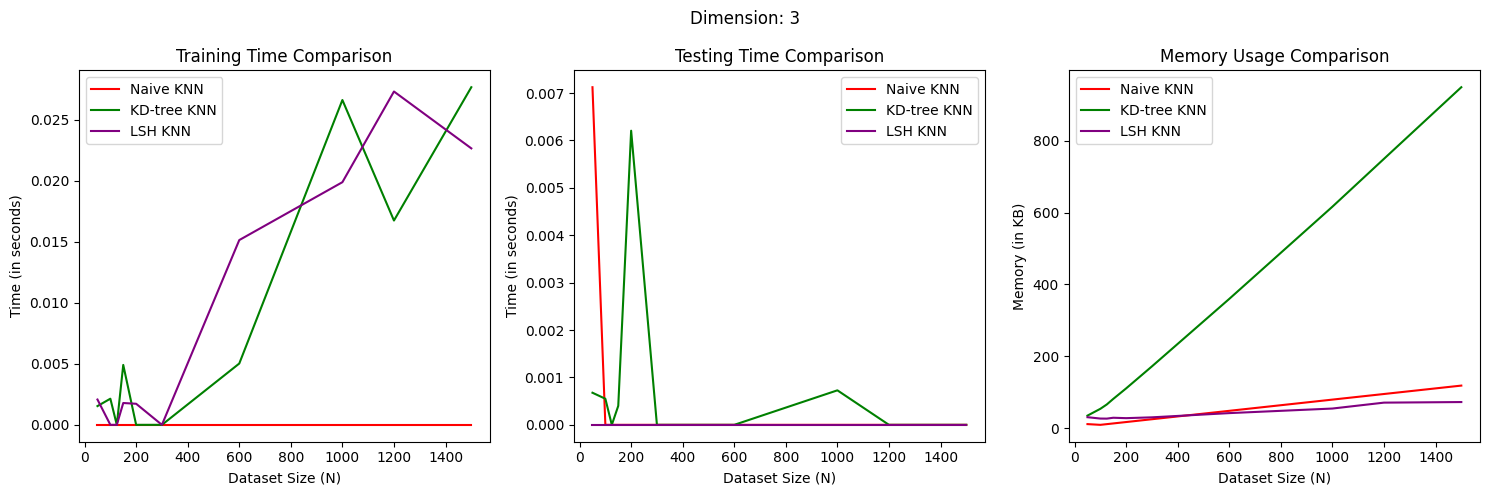

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------


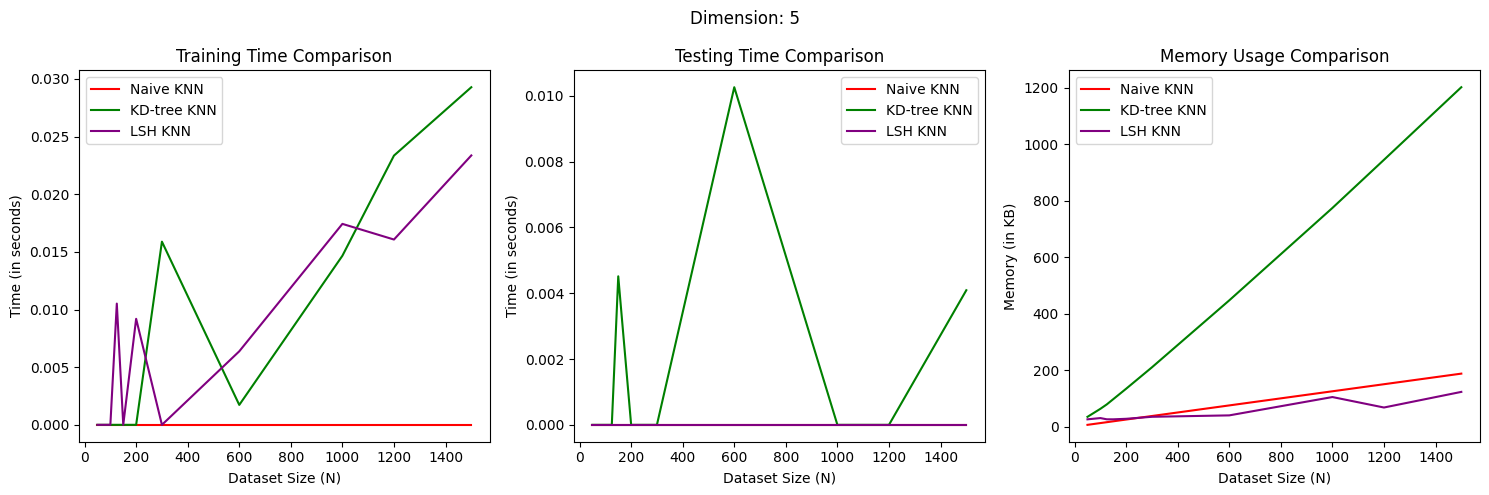

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------


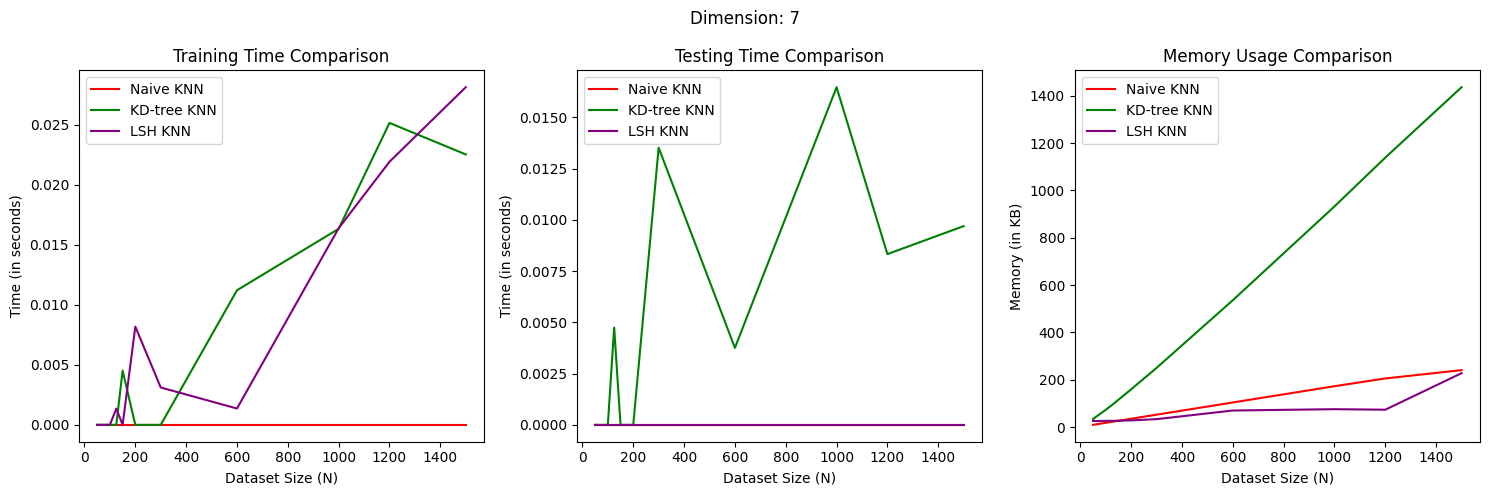

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------


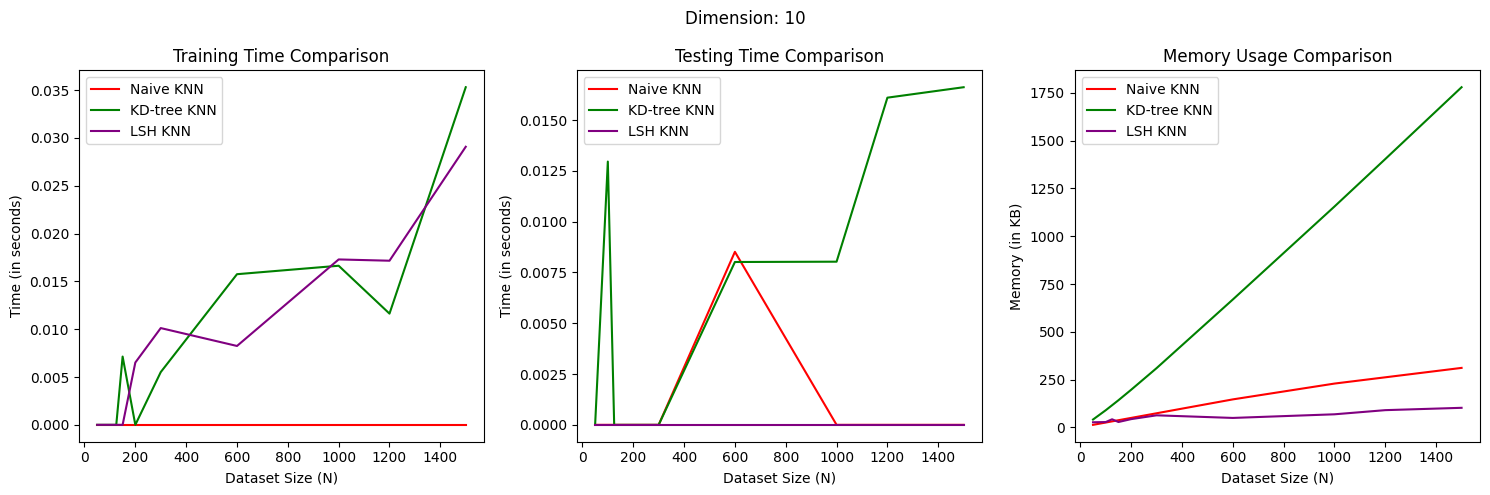

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------


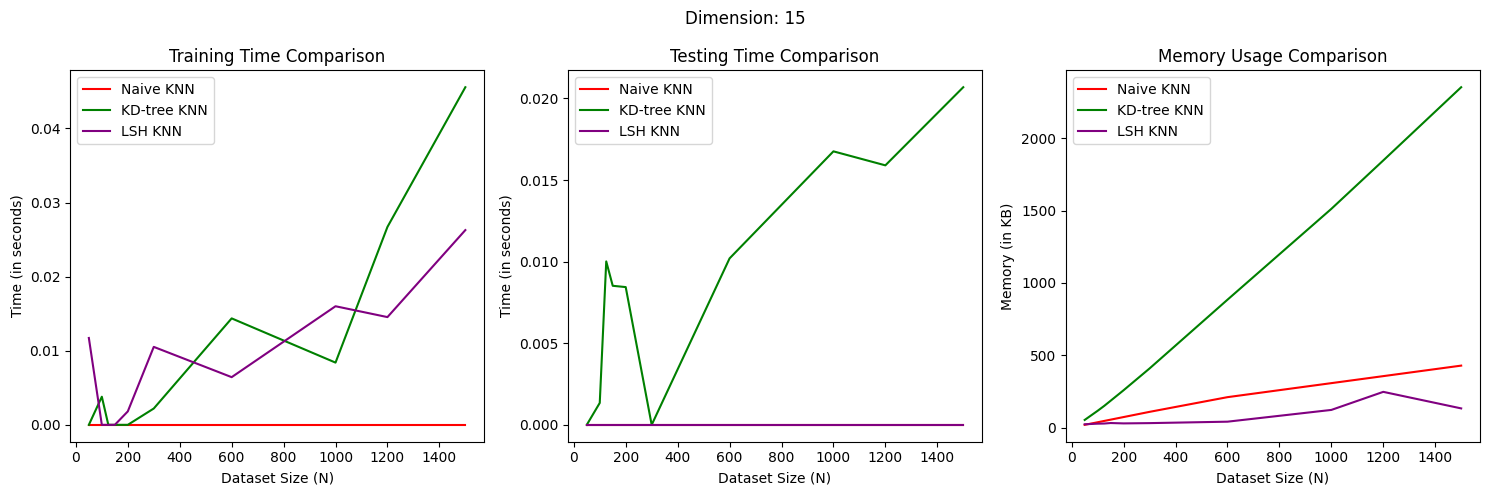

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [9]:
for idx, dimension in enumerate(dimensions):
  fig, axs = plt.subplots(1, 3, figsize=(15, 5))
  fig.suptitle(f"Dimension: {dimension}")

  colors = ['red', 'green', 'purple']
  labels = ["Naive KNN", "KD-tree KNN", "LSH KNN"]

  # Plot training time
  axs[0].plot(sizes, Naive_Train_Time[idx::5], color=colors[0], label=labels[0])
  axs[0].plot(sizes, KDTree_Train_Time[idx::5], color=colors[1], label=labels[1])
  axs[0].plot(sizes, LSH_Train_Time[idx::5], color=colors[2], label=labels[2])
  axs[0].set_xlabel("Dataset Size (N)")
  axs[0].set_ylabel("Time (in seconds)")
  axs[0].set_title("Training Time Comparison")
  axs[0].legend()

  # Plot testing time
  axs[1].plot(sizes, Naive_Test_Time[idx::5], color=colors[0], label=labels[0])
  axs[1].plot(sizes, KDTree_Test_Time[idx::5], color=colors[1], label=labels[1])
  axs[1].plot(sizes, LSH_Test_Time[idx::5], color=colors[2], label=labels[2])
  axs[1].set_xlabel("Dataset Size (N)")
  axs[1].set_ylabel("Time (in seconds)")
  axs[1].set_title("Testing Time Comparison")
  axs[1].legend()

  # Plot memory usage
  axs[2].plot(sizes, Naive_Memory[idx::5], color=colors[0], label=labels[0])
  axs[2].plot(sizes, KDTree_Memory[idx::5], color=colors[1], label=labels[1])
  axs[2].plot(sizes, LSH_Memory[idx::5], color=colors[2], label=labels[2])
  axs[2].set_xlabel("Dataset Size (N)")
  axs[2].set_ylabel("Memory (in KB)")
  axs[2].set_title("Memory Usage Comparison")
  axs[2].legend()

  plt.tight_layout()
  plt.show()
  print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------------")


**Naive KNN takes less training time compared to other approximate KNN methods**


1. ***`No Preprocessing:`* Naive KNN doesn't require any preprocessing steps like building data structures (like hash tables in LSH) for searching nearest neighbors. It simply stores the entire training data.**
2. ***`Simple Distance Calculation:`***

**KD-Tree take More Memory as compared to other because**
1. **Building a multi-dimensional KD-tree data structure during training. *This tree structure requires additional memory* to store the `splitting points, hyperplane orientations, and child node references` at each level of the tree.**

**During the testing time the KDTree takes more time because**
1. **During testing, `it traverses the KD-tree recursively`. It starts from the root node and compares the query point's coordinates with the splitting points at each level. Based on the comparison, it decides which child node to explore further.
This *recursive traversal can be slower than the linear search of Naive KNN*, especially for high-dimensional data.**

---

**Variation in Dimension and Plotting the Graph**

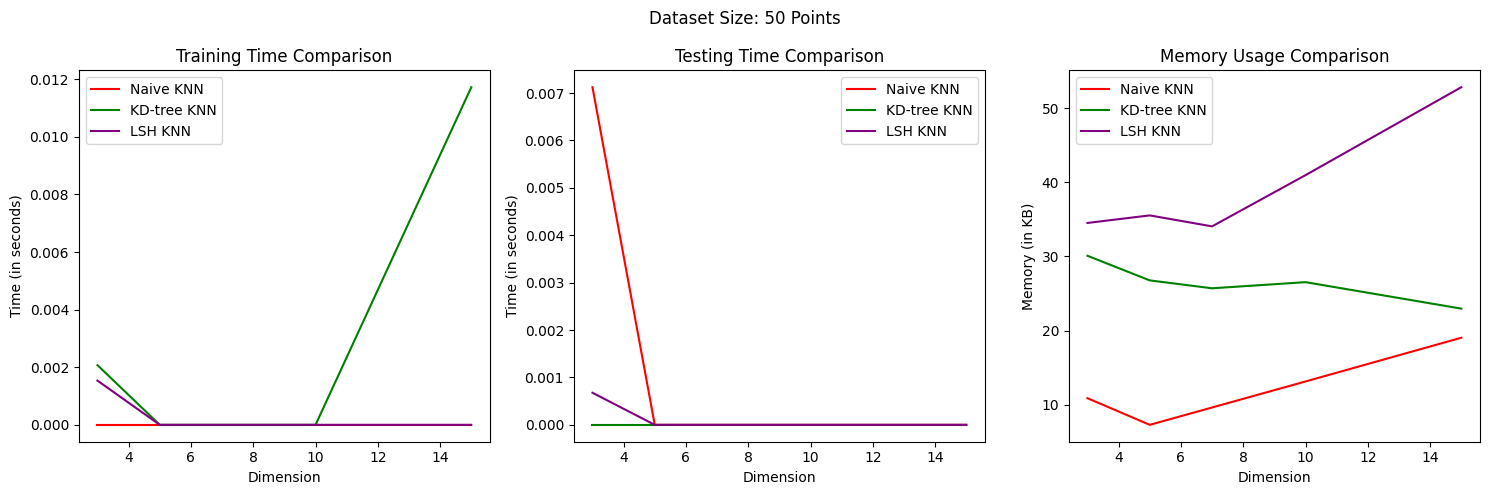

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


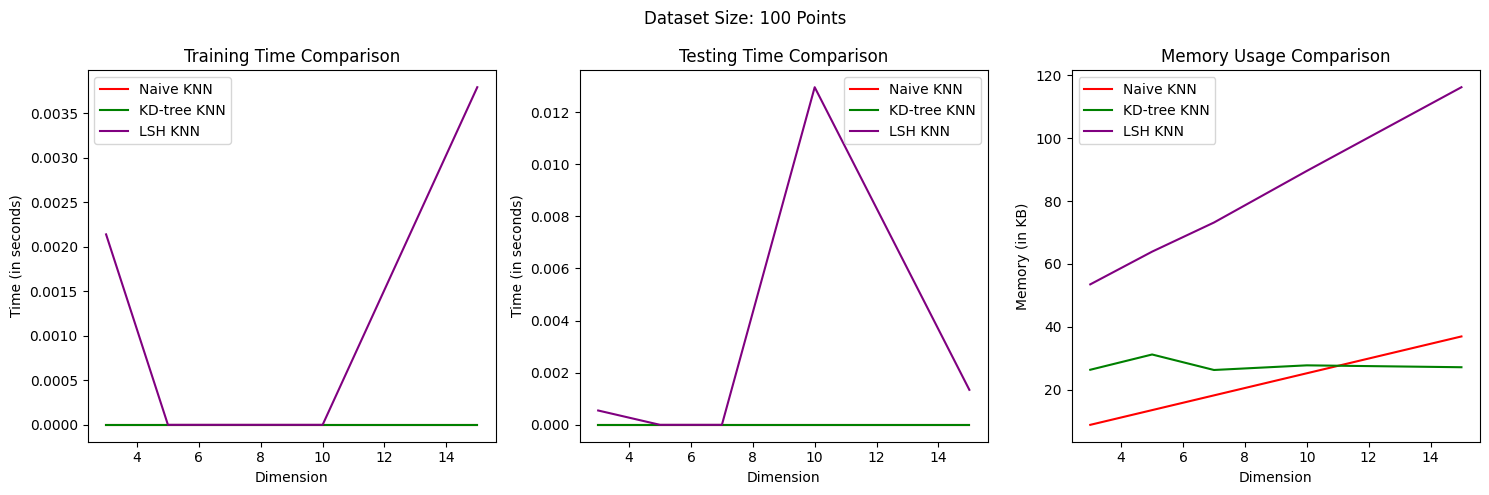

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


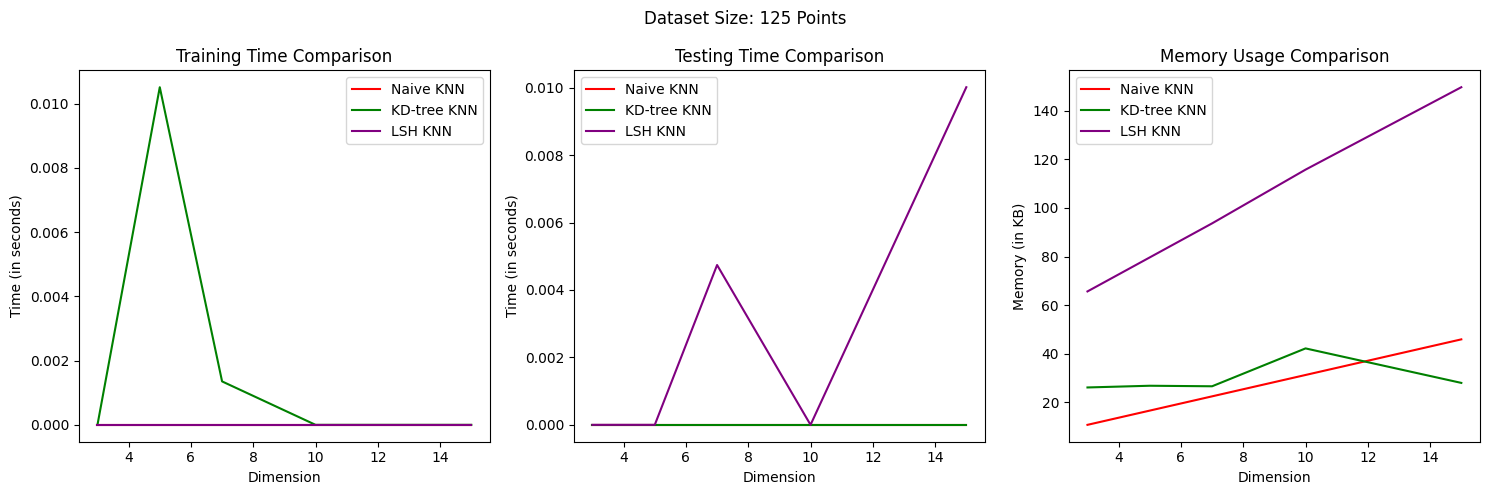

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


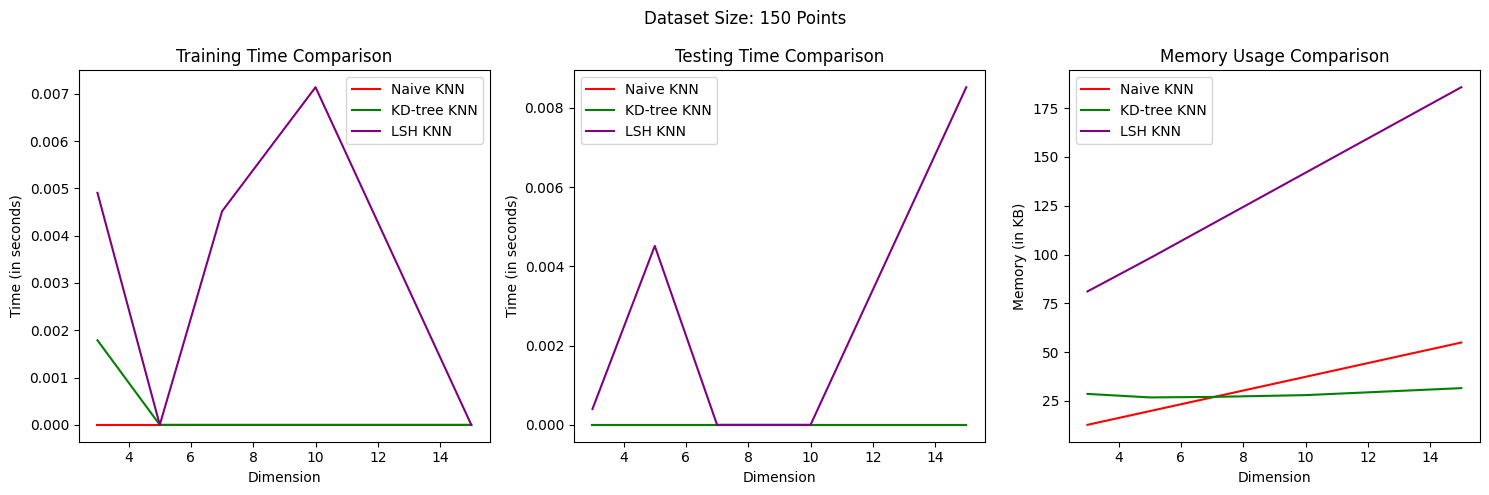

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


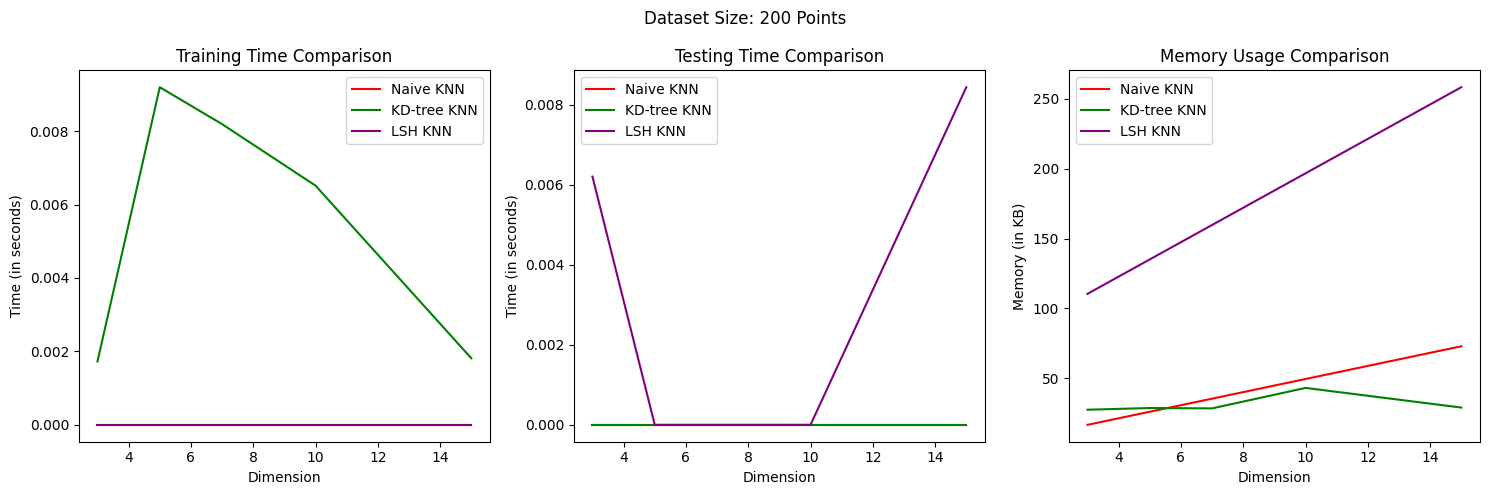

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


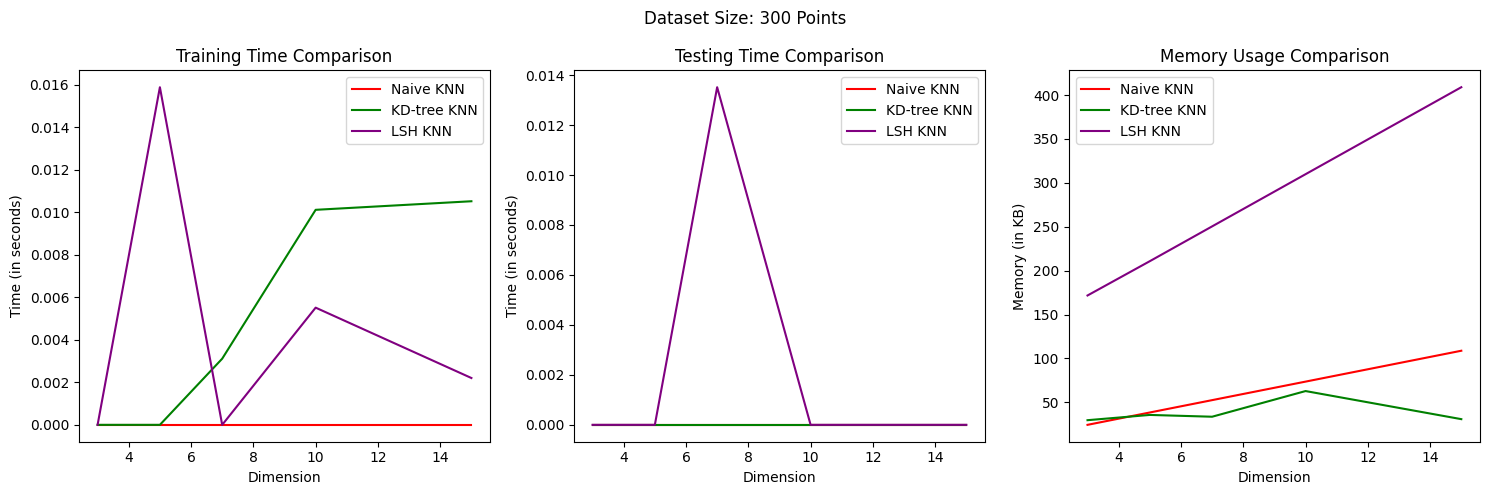

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


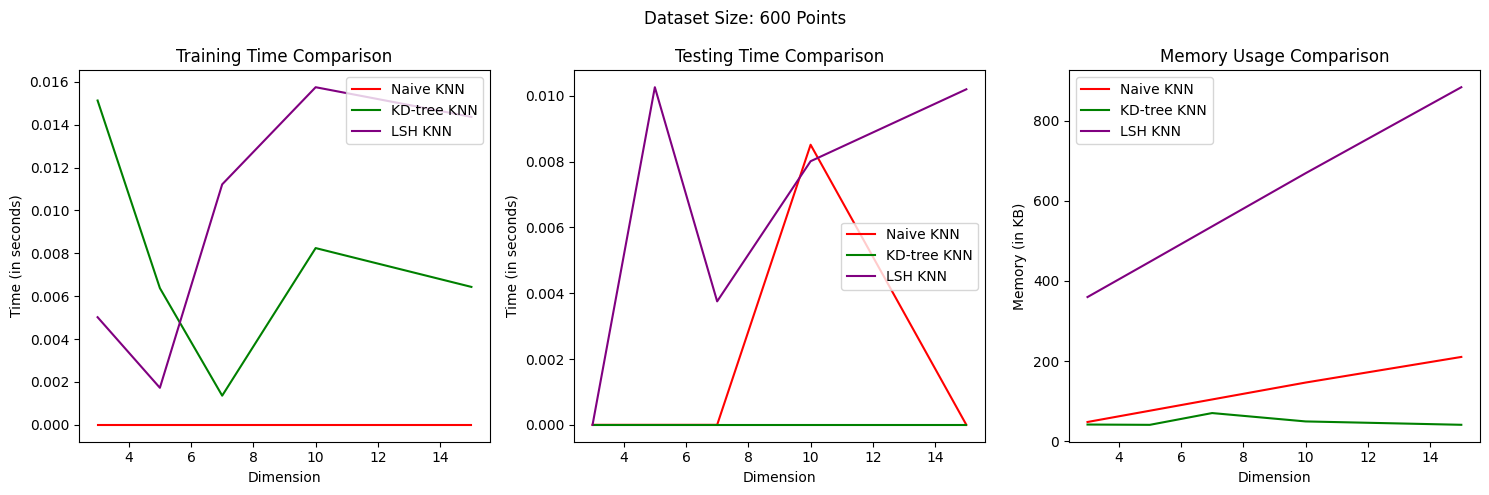

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


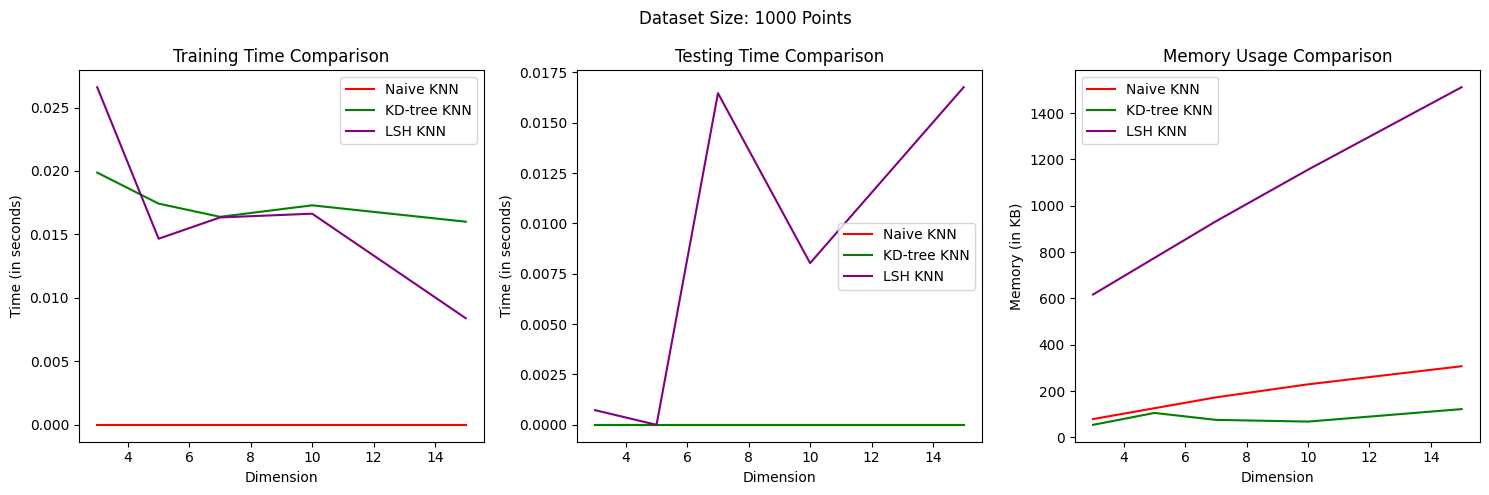

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


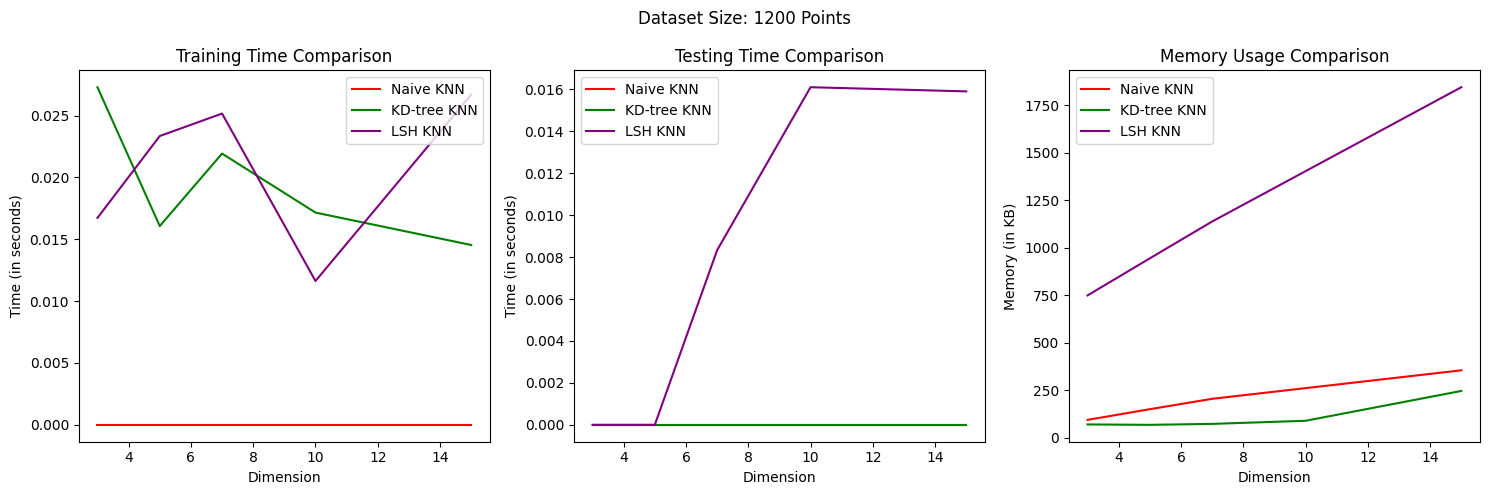

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


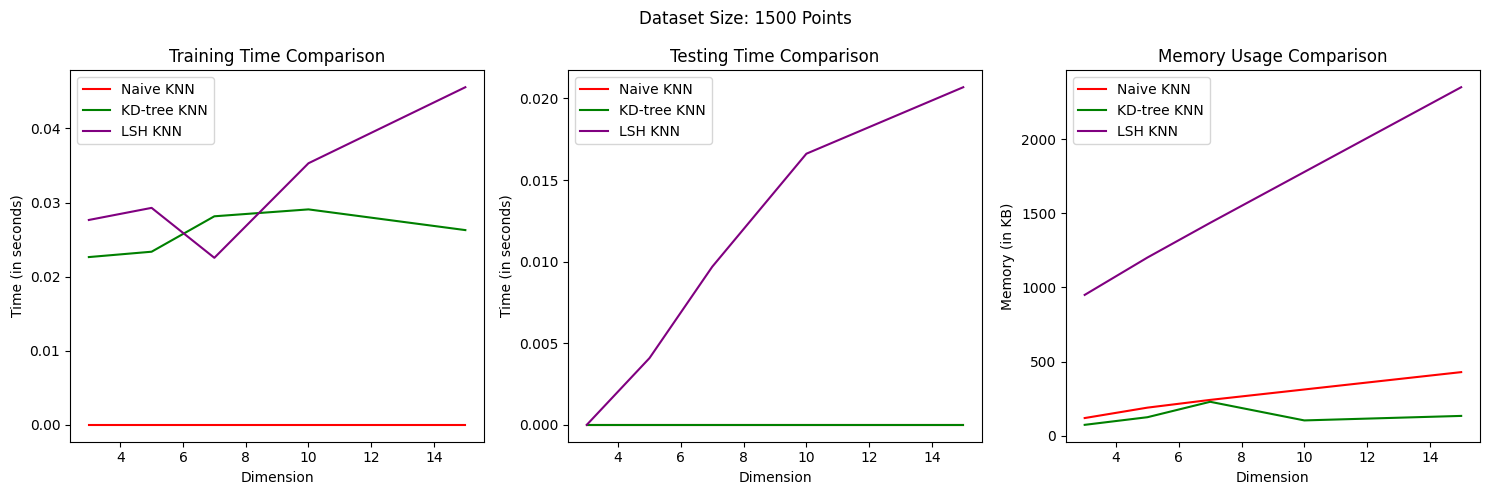

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [10]:
for idx, size in enumerate(sizes):
  fig, axs = plt.subplots(1, 3, figsize=(15, 5))
  fig.suptitle(f"Dataset Size: {size} Points")

  colors = ['red', 'green', 'purple']
  labels = ["Naive KNN", "KD-tree KNN", "LSH KNN"]

  # Plot training time
  axs[0].plot(dimensions, Naive_Train_Time[idx*5:(idx+1)*5], color=colors[0], label=labels[0])
  axs[0].plot(dimensions, LSH_Train_Time[idx*5:(idx+1)*5], color=colors[1], label=labels[1])
  axs[0].plot(dimensions, KDTree_Train_Time[idx*5:(idx+1)*5], color=colors[2], label=labels[2])
  axs[0].set_xlabel("Dimension")
  axs[0].set_ylabel("Time (in seconds)")
  axs[0].set_title("Training Time Comparison")
  axs[0].legend()

  # Plot testing time
  axs[1].plot(dimensions, Naive_Test_Time[idx*5:(idx+1)*5], color=colors[0], label=labels[0])
  axs[1].plot(dimensions, LSH_Test_Time[idx*5:(idx+1)*5], color=colors[1], label=labels[1])
  axs[1].plot(dimensions, KDTree_Test_Time[idx*5:(idx+1)*5], color=colors[2], label=labels[2])
  axs[1].set_xlabel("Dimension")
  axs[1].set_ylabel("Time (in seconds)")
  axs[1].set_title("Testing Time Comparison")
  axs[1].legend()

  # Plot memory usage
  axs[2].plot(dimensions, Naive_Memory[idx*5:(idx+1)*5], color=colors[0], label=labels[0])
  axs[2].plot(dimensions, LSH_Memory[idx*5:(idx+1)*5], color=colors[1], label=labels[1])
  axs[2].plot(dimensions, KDTree_Memory[idx*5:(idx+1)*5], color=colors[2], label=labels[2])
  axs[2].set_xlabel("Dimension")
  axs[2].set_ylabel("Memory (in KB)")
  axs[2].set_title("Memory Usage Comparison")
  axs[2].legend()

  plt.tight_layout()
  plt.show()
  print("---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")


----

**Plots in the 2-D Space**

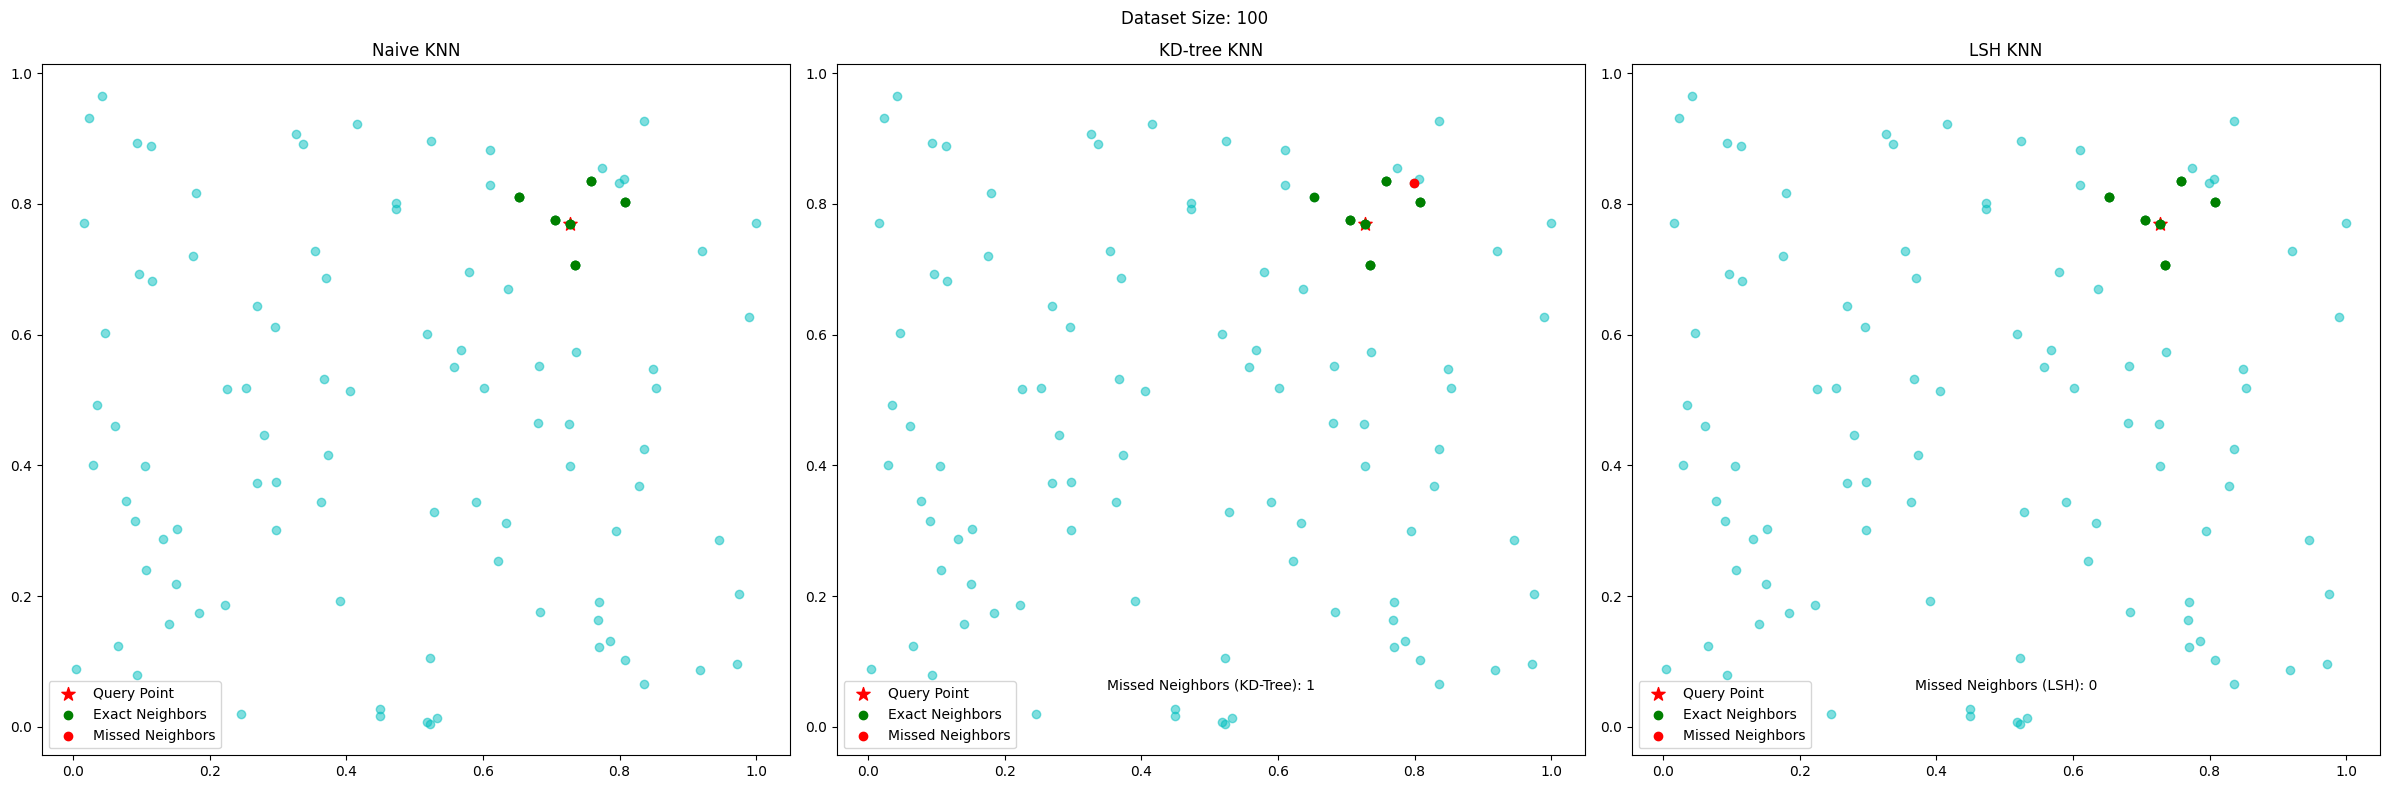

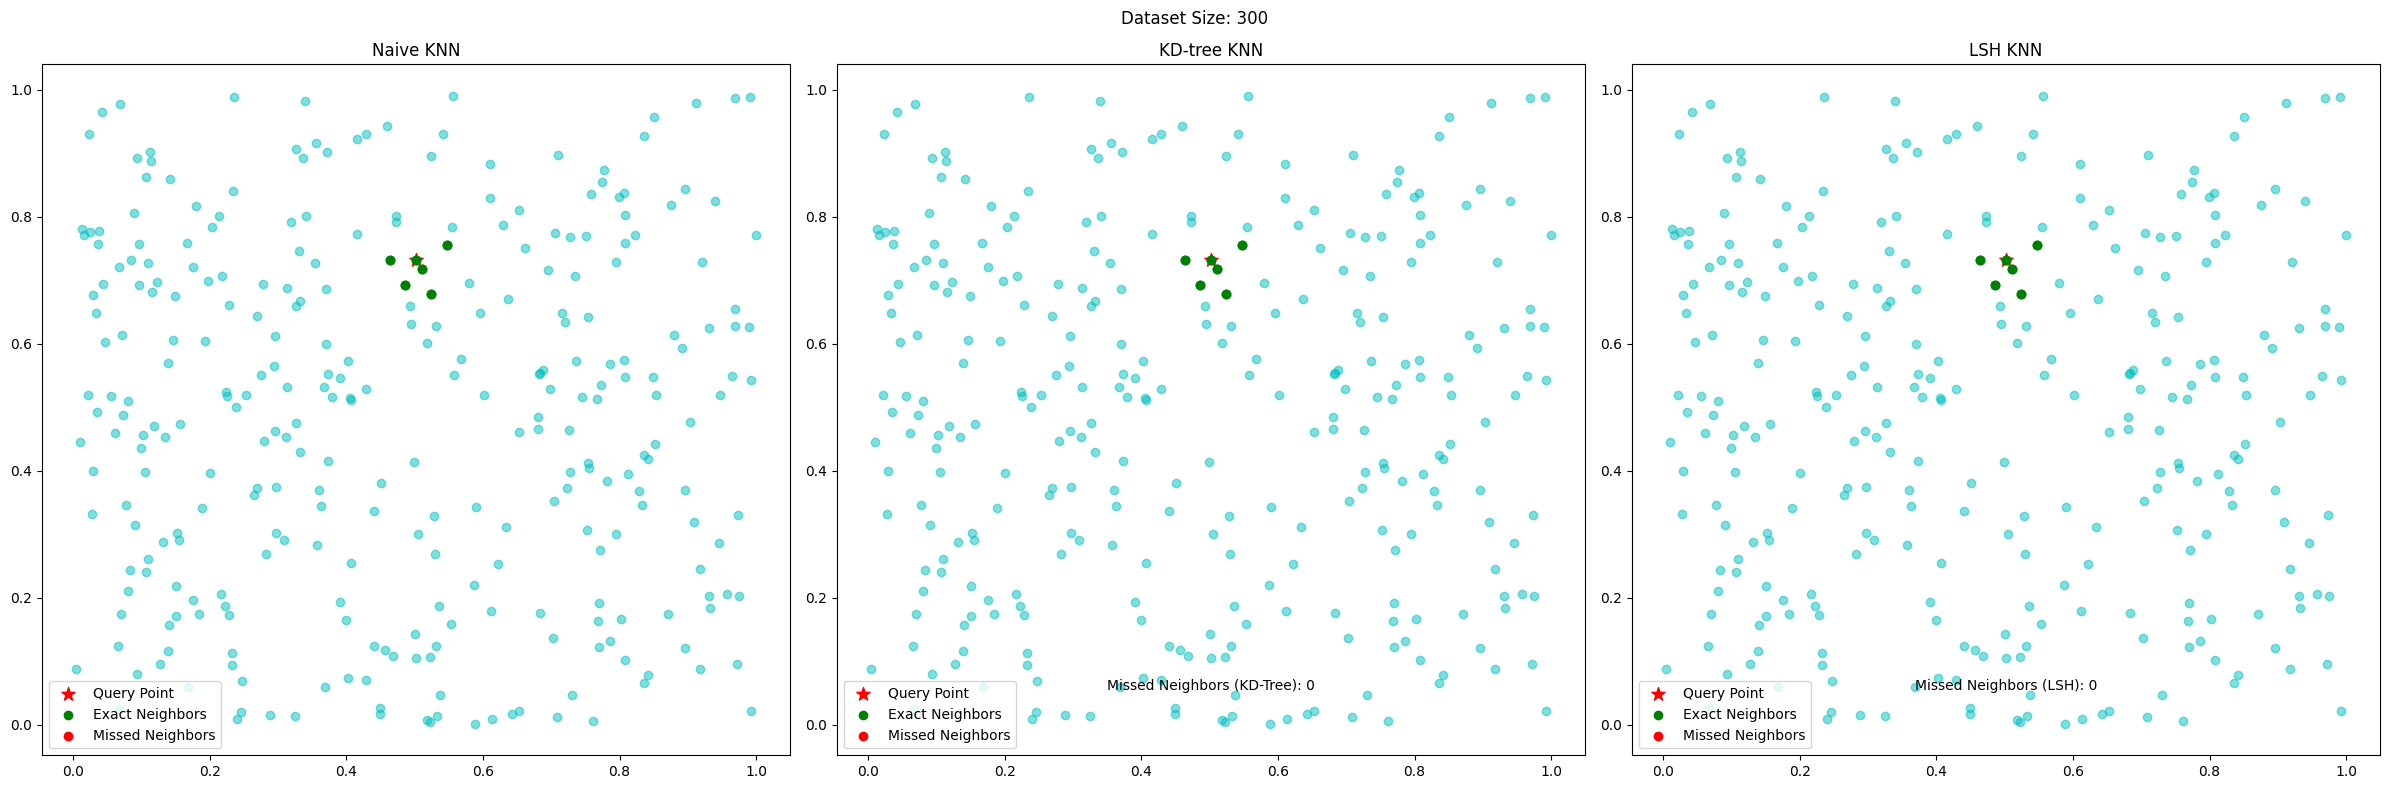

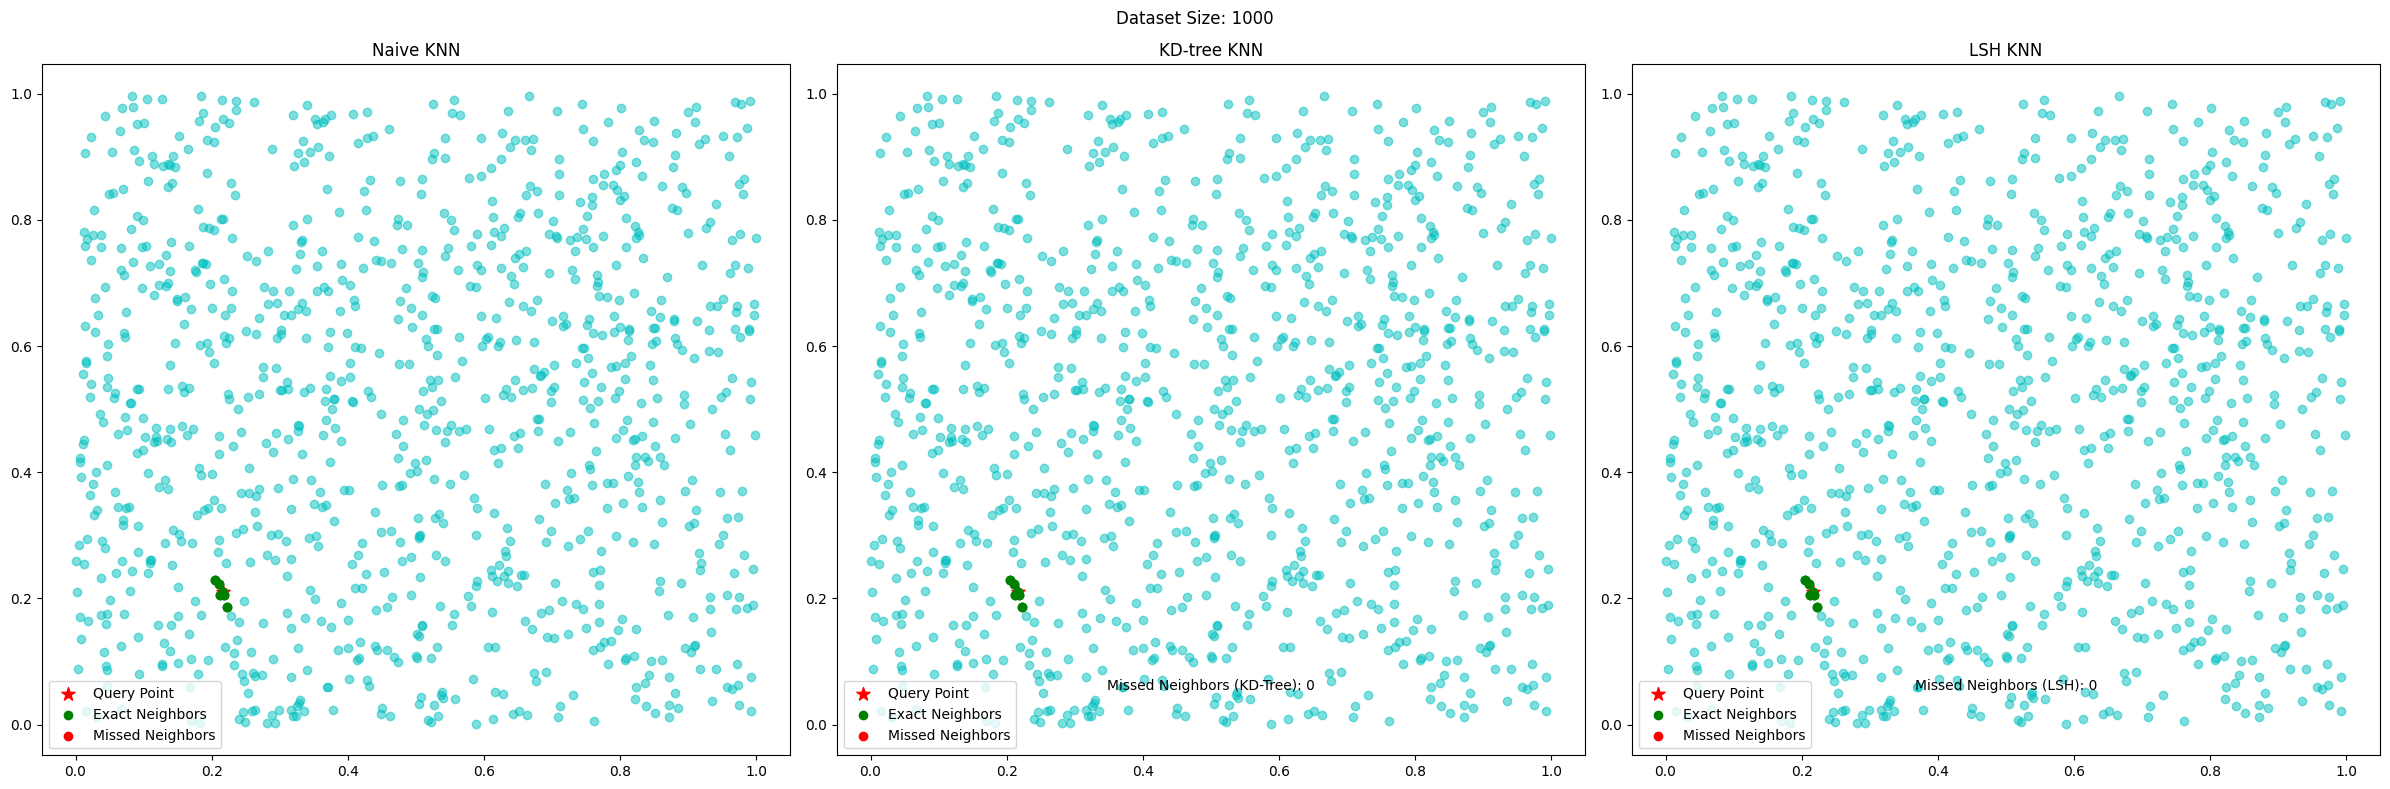

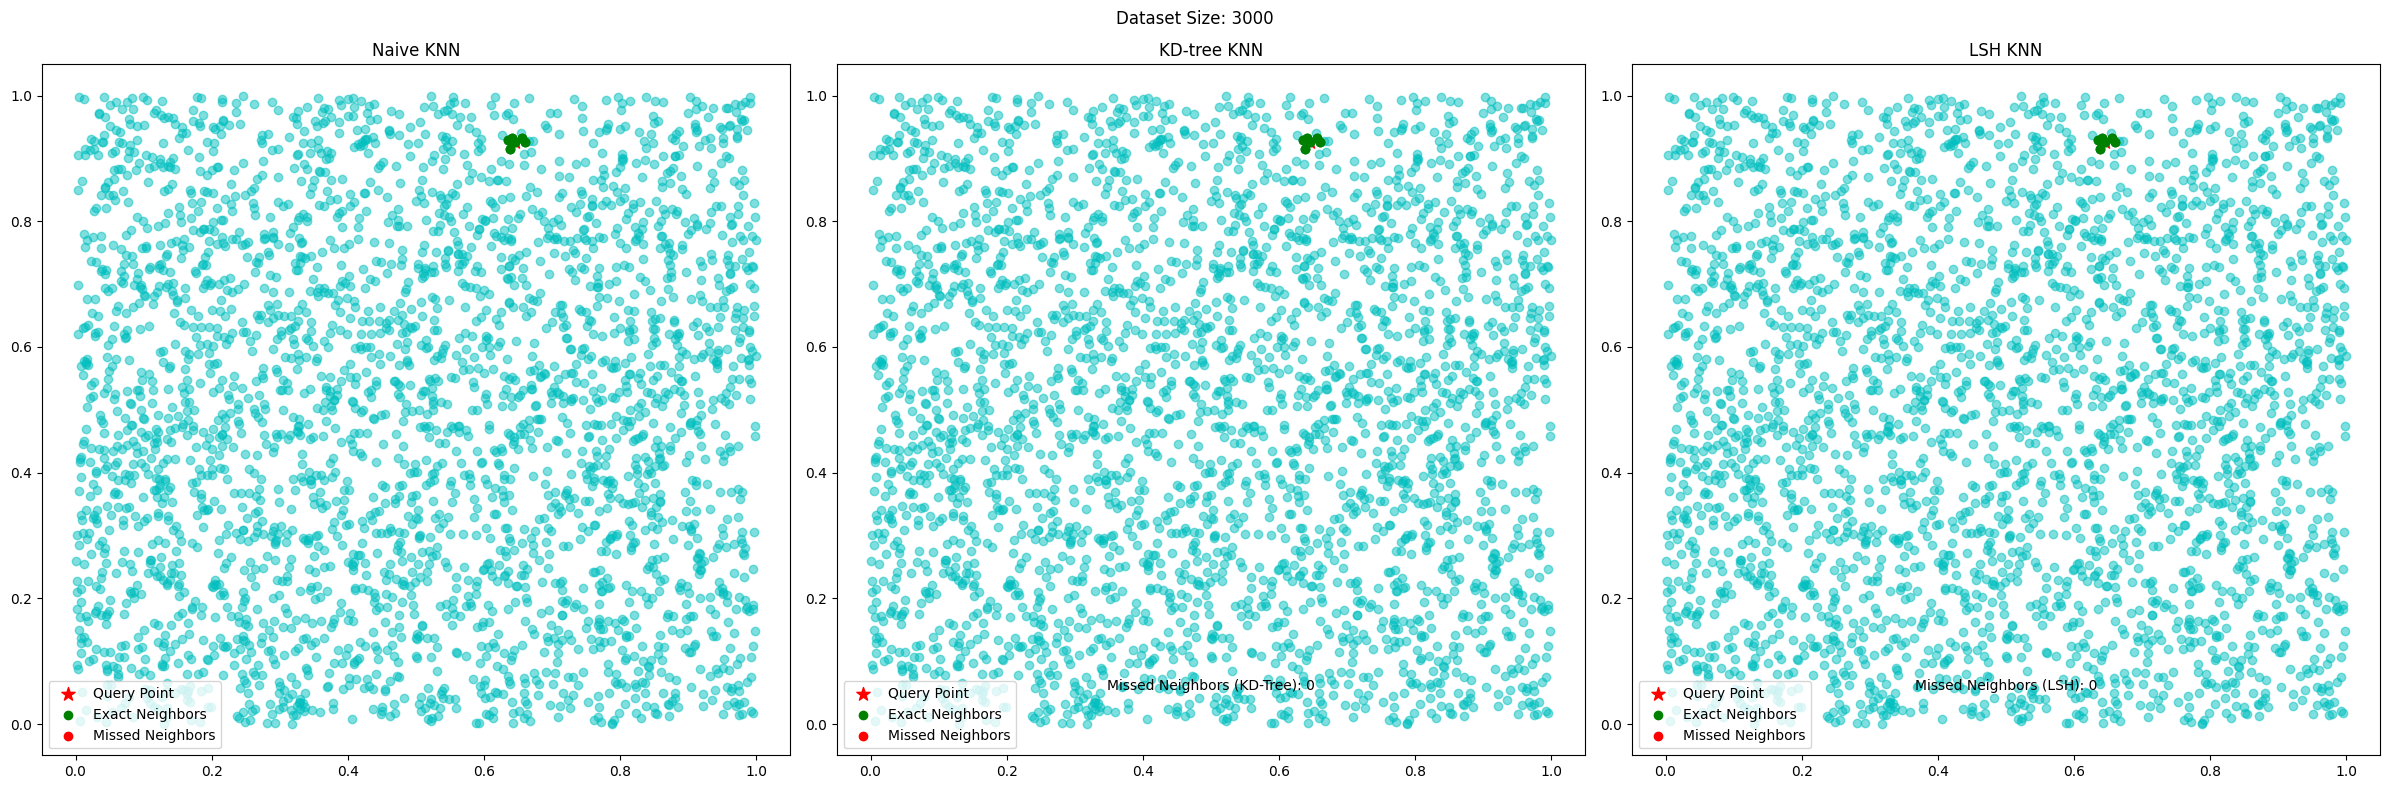

In [11]:

def plot_knn(data, query, naive_neighbors, kdtree_neighbors, LSH_neighbors):
    fig, axs = plt.subplots(1, 3, figsize=(24, 8))
    fig.suptitle(f"Dataset Size: {data_size}")
    data_color = 'c'
    query_color = 'red'
    correct_neighbor_color = 'green'
    missed_neighbor_color = 'red'

    neighbors = [naive_neighbors, kdtree_neighbors, LSH_neighbors]
    names = ['Naive KNN', 'KD-tree KNN', 'LSH KNN']

    for i in range(3):
        axs[i].scatter(data[:, 0], data[:, 1], color=data_color, alpha=0.5)
        axs[i].scatter(query[0], query[1], color=query_color, marker='*', s=100, label='Query Point')

        # Plot exact neighbors found by Naive KNN in green
        axs[i].scatter(data[naive_neighbors, 0], data[naive_neighbors, 1], color=correct_neighbor_color, label='Exact Neighbors')

        # Get method-specific neighbors (KD-Tree or LSH)
        method_neighbors = neighbors[i]
        
        # Find correct and missed neighbors
        correct_neighbors = set(naive_neighbors).intersection(set(method_neighbors))
        missed_neighbors = set(method_neighbors) - correct_neighbors

        # Plot the correct neighbors (green)
        axs[i].scatter(data[list(correct_neighbors), 0], data[list(correct_neighbors), 1], color=correct_neighbor_color)

        # Plot the missed neighbors (red)
        axs[i].scatter(data[list(missed_neighbors), 0], data[list(missed_neighbors), 1], color=missed_neighbor_color, label='Missed Neighbors')

        # Count missed neighbors and annotate on plot
        if i == 1:  # For KD-Tree plot
            missed_count_kdtree = len(missed_neighbors)
            axs[i].text(0.5, 0.1, f'Missed Neighbors (KD-Tree): {missed_count_kdtree}', ha='center', va='center', transform=axs[i].transAxes)
        if i == 2:  # For LSH plot
            missed_count_LSH = len(missed_neighbors)
            axs[i].text(0.5, 0.1, f'Missed Neighbors (LSH): {missed_count_LSH}', ha='center', va='center', transform=axs[i].transAxes)

        axs[i].set_title(names[i])
        axs[i].legend()

    plt.tight_layout()
    plt.show()



data_sizes = [100, 300, 1000, 3000]
for data_size in data_sizes:
    np.random.seed(777)
    data = np.random.rand(data_size, 2)
    query = data[np.random.randint(data_size)]

    Naive_KNN = KNN(data)
    naive_neighbors = Naive_KNN.find_nearest_neighbors(query, k=6)

    KDTree_KNN = KDTree(data)
    kdtree_neighbors = KDTree_KNN.query(query, k=6)

    LSH_KNN = LSH(data)
    LSH_neighbors = LSH_KNN.query_check(query, k=6)

    plot_knn(data, query, naive_neighbors, kdtree_neighbors, LSH_neighbors)

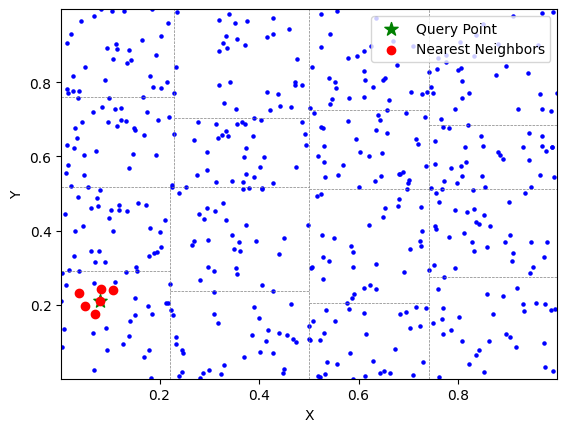

In [12]:
class KDNode:
    def __init__(self, query, axis, Left_Child=None, Right_Child=None):
        self.query = query
        self.axis = axis
        self.Left_Child = Left_Child
        self.Right_Child = Right_Child

class KDTree:
    def __init__(self, data):
        self.data = data
        self.Node = self._build_tree(data, 0)

    def _build_tree(self, data, depth):
        if not data.any():
            return None

        axis = depth % data.shape[1]
        sorted_data = data[data[:, axis].argsort()]
        median = len(data) // 2

        query = sorted_data[median]
        Right_Child = self._build_tree(sorted_data[median + 1:], depth + 1)
        Left_Child = self._build_tree(sorted_data[:median], depth + 1)

        return KDNode(query, axis, Left_Child, Right_Child)

    def query(self, query, k=1):
        def Query_Recursive(Node, query, k, Priority_Queue):
            if Node is None:
                return

            axis = Node.axis
            dist = distance.euclidean(query, Node.query)

            if len(Priority_Queue) < k:
                Priority_Queue.append((dist, Node.query))
            elif dist < Priority_Queue[-1][0]:
                Priority_Queue[-1] = (dist, Node.query)
                Priority_Queue.sort(key=lambda x: x[0])

            if query[axis] < Node.query[axis]:
                Query_Recursive(Node.Left_Child, query, k, Priority_Queue)
                if len(Priority_Queue) < k or abs(query[axis] - Node.query[axis]) < Priority_Queue[-1][0]:
                    Query_Recursive(Node.Right_Child, query, k, Priority_Queue)
            else:
                Query_Recursive(Node.Right_Child, query, k, Priority_Queue)
                if len(Priority_Queue) < k or abs(query[axis] - Node.query[axis]) < Priority_Queue[-1][0]:
                    Query_Recursive(Node.Left_Child, query, k, Priority_Queue)

        Priority_Queue = []
        Query_Recursive(self.Node, query, k, Priority_Queue)

        indices = [np.where((self.data == x[1]).all(axis=1))[0][0] for x in Priority_Queue]
        return indices

    def _plot_partitions(self, node, xmin, xmax, ymin, ymax, depth):
        if node is None or depth == 4:
            return

        xsplit = node.query[0] if node.axis == 0 else xmin + (xmax - xmin) / 2
        ysplit = node.query[1] if node.axis == 1 else ymin + (ymax - ymin) / 2

        if depth % 2 == 0:
            plt.plot([xsplit, xsplit], [ymin, ymax], color='gray', linestyle='--', linewidth=0.5)
            self._plot_partitions(node.Left_Child, xmin, xsplit, ymin, ymax, depth + 1)
            self._plot_partitions(node.Right_Child, xsplit, xmax, ymin, ymax, depth + 1)
        else:
            plt.plot([xmin, xmax], [ysplit, ysplit], color='gray', linestyle='--', linewidth=0.5)
            self._plot_partitions(node.Left_Child, xmin, xmax, ymin, ysplit, depth + 1)
            self._plot_partitions(node.Right_Child, xmin, xmax, ysplit, ymax, depth + 1)


    def plot_partitions(self):
        xmin, xmax = np.min(self.data[:, 0]), np.max(self.data[:, 0])
        ymin, ymax = np.min(self.data[:, 1]), np.max(self.data[:, 1])

        plt.scatter(self.data[:, 0], self.data[:, 1], color='blue', s=5)
        plt.scatter(query[0], query[1], color='green', marker='*', s=100, label='Query Point')
        plt.scatter(data[kdtree.query(query, k=6), 0], data[kdtree.query(query, k=6), 1], color='red', label='Nearest Neighbors')
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.legend()

        self._plot_partitions(self.Node, xmin, xmax, ymin, ymax, 0)

        plt.show()


np.random.seed(777)
data = np.random.rand(500, 2)
query = data[np.random.randint(500)]
kdtree = KDTree(data)
kdtree.plot_partitions()


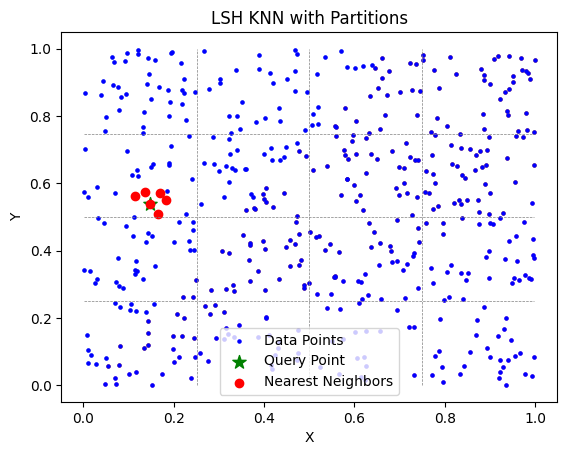

In [13]:
class LSH:
    def __init__(self, data, num_bits=8):
        self.num_bits = num_bits
        self.project_vector = np.random.randn(data.shape[1], num_bits)
        self.buckets = {i: [] for i in range(2**num_bits)}
        self.data = data
        self.put_buckets()

    def put_buckets(self):
        for idx, point in enumerate(self.data):
            hash_val = self.hash_val_convert(point)
            self.buckets[hash_val].append(idx)

    def hash_val_convert(self, point):
        point = point.reshape(1, -1)
        bools = (point @ self.project_vector > 0).astype(int)
        if bools.ndim == 1:
            bools = bools.reshape(1, -1)
        hash_val = 0
        for i in range(self.num_bits):
            hash_val |= bools[0, i] << i
        return hash_val

    def query_check(self, point, k=1):
        hash_val = self.hash_val_convert(point)
        bucket = self.buckets[hash_val]

        members = self.data[bucket]
        distances = np.linalg.norm(members - point, axis=1)
        nearest_idx = np.argpartition(distances, k)[:k]
        nearest_idx = np.asarray(nearest_idx, dtype=int)

        return [bucket[i] for i in nearest_idx]

    def plot_partitions(self):
        num_buckets = len(self.buckets)
        colors = plt.cm.tab20(np.linspace(0, 1, num_buckets))
        for i, (bucket, indices) in enumerate(self.buckets.items()):
            if not indices:
                continue
            points = self.data[indices]
            plt.scatter(points[:, 0], points[:, 1], color=colors[i], s=5)

        for axis in range(self.data.shape[1]):
            min_val = np.min(self.data[:, axis])
            max_val = np.max(self.data[:, axis])
            num_lines = 3
            partition_points = np.linspace(min_val, max_val, num_lines + 2)[1:-1]
            for point in partition_points:
                if axis == 0:
                    plt.plot([point] * 2, [min_val, max_val], color='gray', linestyle='--', linewidth=0.5)
                else:
                    plt.plot([min_val, max_val], [point] * 2, color='gray', linestyle='--', linewidth=0.5)

        plt.scatter(self.data[:, 0], self.data[:, 1], color='blue', s=5, label='Data Points')
        plt.scatter(query[0], query[1], color='green', marker='*', s=100, label='Query Point')
        plt.scatter(self.data[self.query_check(query, k=6), 0], self.data[self.query_check(query, k=6), 1], color='red', label='Nearest Neighbors')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.legend()
        plt.title('LSH KNN with Partitions')
        plt.show()


np.random.seed(783)
data = np.random.rand(500, 2)
query = data[np.random.randint(500)]
LSH_KNN = LSH(data)
LSH_KNN.plot_partitions()
